In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3566525482647295602
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5726273536
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9928549752718408825
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
]


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import cv2
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df = pd.read_csv('./train.csv')
print("size of train_df:", len(train_df))

# 데이터 노이즈 수정
train_df.loc[train_df['id'] == 3896, 'artist'] = 'Titian'
train_df.loc[train_df['id'] == 3986, 'artist'] = 'Alfred Sisley'

DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    data_format="channels_last",
    validation_split=0.10
)

TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
    dataframe=train_df,
    x_col='img_path',
    y_col='artist',
    target_size=(244, 244),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset="training"
)

VALID_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
    dataframe=train_df,
    x_col='img_path',
    y_col='artist',
    target_size=(244, 244),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset="validation"
)

size of train_df: 5911
Found 5320 validated image filenames belonging to 50 classes.
Found 591 validated image filenames belonging to 50 classes.


In [4]:
# ResNet50 모델 로드
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(244, 244, 3), pooling=None, input_tensor=None)

# 새로운 Fully Connected Layer 추가
x = base_model.output
x = Flatten()(x)
x = Dropout(0.2)(x) # 드롭아웃 추가
predictions = Dense(50, activation='softmax')(x)

#전체 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
CP = ModelCheckpoint(filepath='vgg19_model/' + 'VGG19-Sigmoid-{epoch:03d}-{accuracy:.4f}-{val_loss:.4f}.hdf5',
                     monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=0.00005)
CALLBACK = [CP, LR]

In [6]:
# 모델 학습
history = model.fit(
    TRAIN_GENERATOR,
    epochs=100,
    validation_data=VALID_GENERATOR,
    callbacks=CALLBACK,
)

Epoch 1/100
167/167 [==============================] - 70s 392ms/step - loss: 3.6609 - accuracy: 0.1090 - val_loss: 3.5006 - val_accuracy: 0.1421

Epoch 00001: val_loss improved from inf to 3.50058, saving model to vgg19_model\VGG19-Sigmoid-001-0.1090-3.5006.hdf5
Epoch 2/100
167/167 [==============================] - 64s 380ms/step - loss: 3.4307 - accuracy: 0.1462 - val_loss: 3.3313 - val_accuracy: 0.1692

Epoch 00002: val_loss improved from 3.50058 to 3.33127, saving model to vgg19_model\VGG19-Sigmoid-002-0.1462-3.3313.hdf5
Epoch 3/100
167/167 [==============================] - 64s 382ms/step - loss: 3.2500 - accuracy: 0.1675 - val_loss: 3.1529 - val_accuracy: 0.1827

Epoch 00003: val_loss improved from 3.33127 to 3.15289, saving model to vgg19_model\VGG19-Sigmoid-003-0.1675-3.1529.hdf5
Epoch 4/100
167/167 [==============================] - 89s 533ms/step - loss: 3.1534 - accuracy: 0.1759 - val_loss: 3.3081 - val_accuracy: 0.1557

Epoch 00004: val_loss did not improve from 3.15289
Ep

Epoch 36/100
167/167 [==============================] - 65s 387ms/step - loss: 2.1839 - accuracy: 0.3831 - val_loss: 2.4721 - val_accuracy: 0.3706

Epoch 00036: val_loss did not improve from 2.42936
Epoch 37/100
167/167 [==============================] - 63s 378ms/step - loss: 2.1549 - accuracy: 0.3897 - val_loss: 2.3608 - val_accuracy: 0.3807

Epoch 00037: val_loss improved from 2.42936 to 2.36078, saving model to vgg19_model\VGG19-Sigmoid-037-0.3897-2.3608.hdf5
Epoch 38/100
167/167 [==============================] - 63s 374ms/step - loss: 2.1677 - accuracy: 0.3846 - val_loss: 2.3575 - val_accuracy: 0.3672

Epoch 00038: val_loss improved from 2.36078 to 2.35746, saving model to vgg19_model\VGG19-Sigmoid-038-0.3846-2.3575.hdf5
Epoch 39/100
167/167 [==============================] - 63s 373ms/step - loss: 2.1243 - accuracy: 0.3961 - val_loss: 2.4390 - val_accuracy: 0.3367

Epoch 00039: val_loss did not improve from 2.35746
Epoch 40/100
167/167 [==============================] - 63s 378m

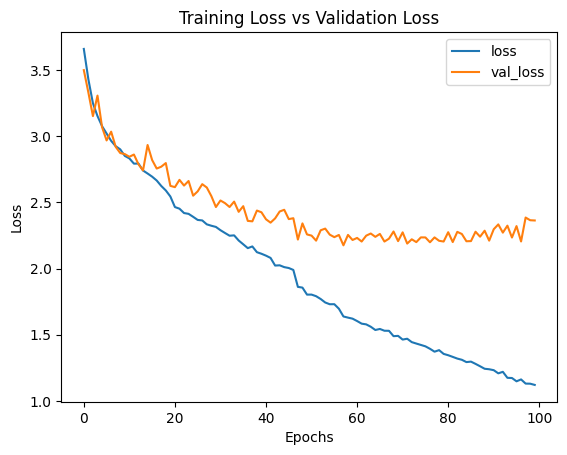

In [7]:
# 손실 그래프
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

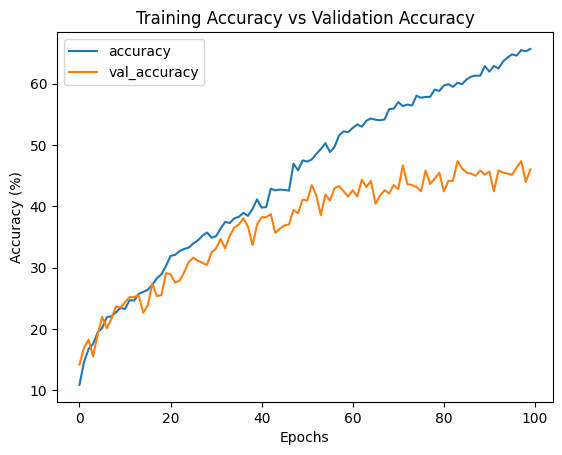

In [8]:
# 정확도 그래프
plt.plot([x * 100 for x in history.history['accuracy']])
plt.plot([x * 100 for x in history.history['val_accuracy']])
plt.title('Training Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [9]:
# 최신 체크포인트 파일 찾기
checkpoint_files = glob.glob('vgg19_model/*.hdf5')
latest_checkpoint = max(checkpoint_files, key=os.path.getctime)

# 모델에 최신 가중치 로드
model.load_weights(latest_checkpoint)

# Validation 데이터에 대한 정확도 확인
val_loss, val_accuracy = model.evaluate(VALID_GENERATOR)
print('Validation Loss:', round(val_loss, 6))
print('Validation Accuracy:', round(val_accuracy, 3))

19/19 [==============================] - 6s 314ms/step - loss: 2.2695 - accuracy: 0.4112
Validation Loss: 2.269494
Validation Accuracy: 0.411


In [10]:
test_df = pd.read_csv('test.csv')

TEST_GENERATOR = DATAGEN_TRAIN.flow_from_dataframe(
    dataframe=test_df,
    x_col='img_path',
    y_col='id',
    target_size=(244, 244),
    class_mode='raw',
    batch_size=32,
    shuffle=False,
)

TEST_GENERATOR.reset()

# 최신 체크포인트 파일 찾기
checkpoint_files = glob.glob('vgg19_model/*.hdf5')
latest_checkpoint = max(checkpoint_files, key=os.path.getctime)

print(latest_checkpoint)

# 모델에 최신 가중치 로드
model.load_weights(latest_checkpoint)

test_prediction = model.predict(TEST_GENERATOR, verbose=1)
display(test_prediction)

Found 12670 validated image filenames.
vgg19_model\VGG19-Sigmoid-058-0.5158-2.1761.hdf5
396/396 [==============================] - 216s 546ms/step


array([[1.84279983e-03, 5.71724377e-04, 2.08239863e-03, ...,
        4.94196399e-07, 5.07502630e-02, 3.87512520e-03],
       [2.31538826e-04, 3.49224429e-05, 1.42758995e-01, ...,
        1.13683200e-04, 5.32630645e-03, 1.23641384e-03],
       [3.01240245e-04, 1.78069895e-04, 1.64037774e-05, ...,
        1.50498568e-06, 1.17663436e-01, 5.28499542e-04],
       ...,
       [1.45486242e-03, 2.77141389e-05, 7.69841252e-04, ...,
        4.15154645e-05, 1.36014074e-01, 1.93690956e-02],
       [6.59561949e-04, 7.86623350e-05, 5.21379625e-05, ...,
        4.55854104e-10, 1.73585974e-02, 3.82935908e-03],
       [3.62548963e-06, 2.50943740e-05, 9.09706887e-06, ...,
        1.17003456e-05, 1.62895750e-02, 2.72031575e-05]], dtype=float32)

In [11]:
test_prediction = np.argmax(test_prediction, axis = 1)
test_prediction

array([10, 10, 32, ..., 33, 42, 45], dtype=int64)

In [12]:
test_prediction_df = pd.DataFrame(test_prediction, columns = ['artist'])
test_prediction_df

,artist
0,10
1,10
2,32
3,0
4,48
...,...
12665,35
12666,33
12667,33
12668,42


In [14]:
label_encoder = LabelEncoder()
artist_df = train_df.copy()
artist_le = label_encoder.fit_transform(artist_df['artist'].values)
artist_df['num'] = artist_le
artist_df = artist_df.drop('id', axis=1)
artist_df = artist_df.drop('img_path', axis=1)
test_prediction_dic = test_prediction_df.to_dict()
test_prediction_values = test_prediction_dic['artist'].values()
test_prediction_list = list(test_prediction_values)
artist_df.set_index('num', inplace=True)
artist_df = artist_df.sort_index()
artist_info_dic = artist_df['artist'].to_dict()

In [15]:
artist_name = []
for i in test_prediction_list:
    artist_name.append(artist_info_dic[i])
artist_name[:5]

['Edgar Degas',
 'Edgar Degas',
 'Mikhail Vrubel',
 'Albrecht Du rer',
 'Vincent van Gogh']

In [16]:
submission_df = pd.read_csv("./sample_submission.csv")
submission_df = submission_df.drop('artist', axis=1)
submission_df.head()

,id
0,TEST_00000
1,TEST_00001
2,TEST_00002
3,TEST_00003
4,TEST_00004


In [17]:
submission_df['artist'] = artist_name
submission_df.head()

,id,artist
0,TEST_00000,Edgar Degas
1,TEST_00001,Edgar Degas
2,TEST_00002,Mikhail Vrubel
3,TEST_00003,Albrecht Du rer
4,TEST_00004,Vincent van Gogh


In [18]:
submission_df.to_csv("vgg19_submission.csv", index=False)